In [1]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
import pickle
import glob
from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

In [2]:
class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))+c

def Gauss_2d_LC_func_gen(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt_gen(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V


In [3]:
## AUGUST 26 FLIGHT READ IN

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

#just look at 3 flights with the same drone transmitter orientation

for key in ['20210826T170324Z', '20210826T182915Z','20210826T195014Z']: 
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)


20210826T170324Z
20210826T182915Z
20210826T195014Z


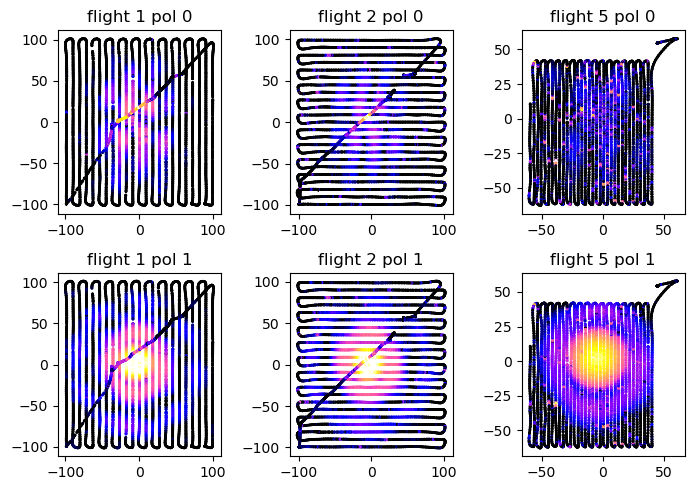

In [4]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    try: 
        dotsize=1
        freq = 900
        inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
        indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
        x = dict826[i].drone_xyz_LC_interp[indsuse,0]
        y = dict826[i].drone_xyz_LC_interp[indsuse,1]

        ax=fig.add_subplot(2,6,counter)
        z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
        ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
        ax.set_title('flight '+str(k) + ' pol 0')

        ax=fig.add_subplot(2,6,counter+6)
        z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
        ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
        ax.set_title('flight '+str(k) + ' pol 1')
        counter +=1

    except: pass
# suptitle('August Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

In [26]:
res = 500

X,Y = np.meshgrid(np.linspace(-100,100,500), np.linspace(-100,100,500))


num = 1
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
x1 = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y1 = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z1 = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z1 = griddata((x,y), z, (X,Y))


num = 2
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z2 = griddata((x,y), z, (X,Y))


num = 5
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z5 = griddata((x,y), z, (X,Y))


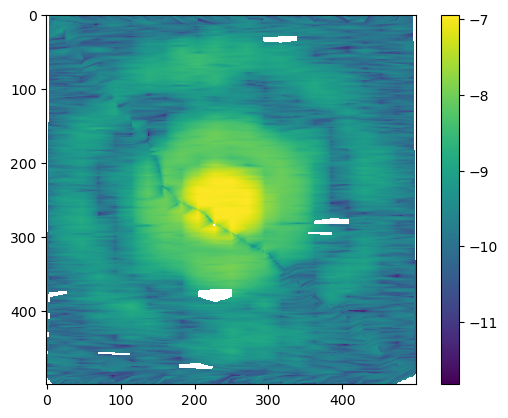

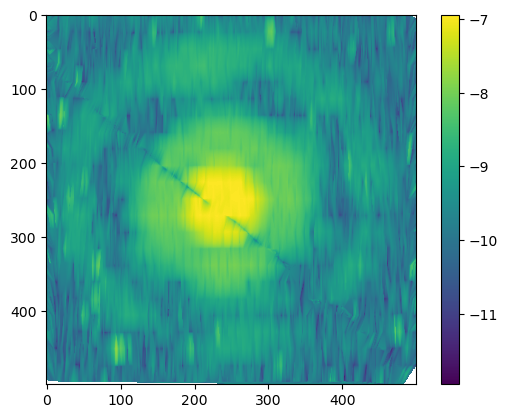

In [13]:
#flight 1 
imshow(np.log10(Z1[:,:,900]))
colorbar()
show()
 
# flight 2 
imshow(np.log10(Z2[:,:,900]))
colorbar()
show()

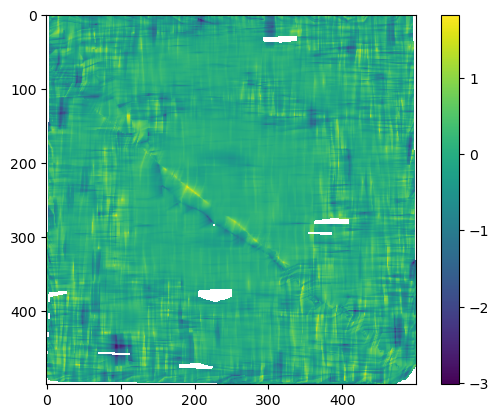

In [56]:
#difference of two flights
imshow(np.log10(Z1[:,:,900])-np.log10(Z2[:,:,900]))
colorbar()


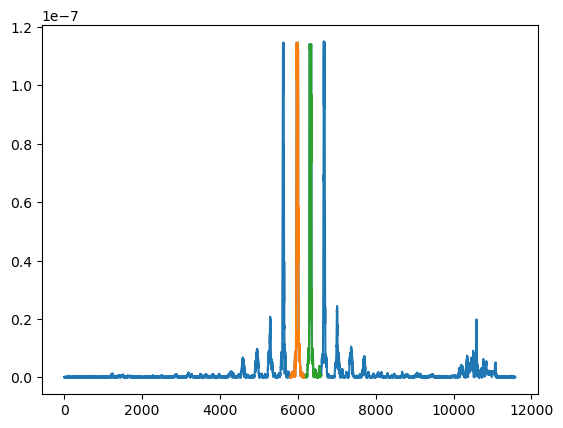

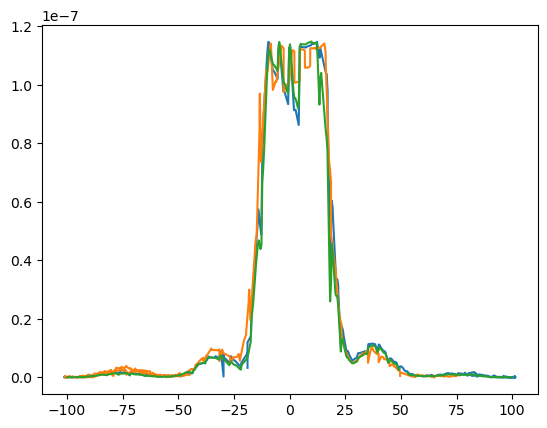

In [55]:
#basic check of interpolated data against actual data 
lb = 5800
ub = 6200
plot(z1[:,900])
plot(np.arange(len(z1[:,900]))[lb:ub], z1[:,900][lb:ub])
lb = 6200
ub = 6600
plot(np.arange(len(z1[:,900]))[lb:ub], z1[:,900][lb:ub])

show()

lb = 5800
ub = 6200
plot(y1[lb:ub], z1[:,900][lb:ub])
lb = 6200
ub = 6600
plot(y1[lb:ub], z1[:,900][lb:ub])
plot(X[250,:], np.mean(Z1[:,250,900:910], axis = 1))
